# Goal

* Follow-up to: `atomIncorp_taxaIncorp`
* Determining the effect of 'heavy' BD window (number of windows & window sizes) on HR-SIP accuracy

### Variable parameters:

* 'heavy' BD window sizes

## Init

In [62]:
import os
import glob
import itertools
import nestly

In [63]:
%load_ext rpy2.ipython
%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The pushnote extension is already loaded. To reload it, use:
  %reload_ext pushnote


In [64]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

### BD min/max

In [65]:
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_BD = min_GC/100.0 * 0.098 + 1.66    
max_BD = max_GC/100.0 * 0.098 + 1.66    

max_BD = max_BD + max_13C_shift_in_BD

print 'Min BD: {}'.format(min_BD)
print 'Max BD: {}'.format(max_BD)

Min BD: 1.67323
Max BD: 1.7744


# Nestly

* assuming fragments already simulated

In [66]:
# paths
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1147/'
buildDir = os.path.join(workDir, 'atomIncorp_taxaIncorp_MW-HR-SIP')
dataDir = os.path.join(workDir, 'atomIncorp_taxaIncorp')

In [67]:
if not os.path.isdir(buildDir):
    os.makedirs(buildDir)
%cd $buildDir

/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP


In [68]:
# making an experimental design file for qSIP
x = range(1,7)
y = ['control', 'treatment']

expDesignFile = os.path.join(buildDir, 'qSIP_exp_design.txt')
with open(expDesignFile, 'wb') as outFH:
    for i,z in itertools.izip(x,itertools.cycle(y)):
        line = '\t'.join([str(i),z])
        outFH.write(line + '\n')

!head $expDesignFile       

1	control
2	treatment
3	control
4	treatment
5	control
6	treatment


## Nestly params

In [69]:
# building tree structure
nest = nestly.Nest()


# varying params
nest.add('percIncorp', [0, 15, 25, 50, 100])
nest.add('percTaxa', [1, 5, 10, 25, 50])
nest.add('rep', range(1,11))

## set params
nest.add('abs', ['1e9'], create_dir=False)
nest.add('np', [10], create_dir=False)
nest.add('Monte_rep', [100000], create_dir=False)
nest.add('subsample_dist', ['lognormal'], create_dir=False)
nest.add('subsample_mean', [9.432], create_dir=False)
nest.add('subsample_scale', [0.5], create_dir=False)
nest.add('subsample_min', [10000], create_dir=False)
nest.add('subsample_max', [30000], create_dir=False)
nest.add('min_BD', [min_BD], create_dir=False)
nest.add('max_BD', [max_BD], create_dir=False)
nest.add('DBL_scaling', [0.5], create_dir=False)
nest.add('bandwidth', [0.8], create_dir=False)
nest.add('heavy_BD_min', [1.71], create_dir=False)
nest.add('heavy_BD_max', [1.75], create_dir=False)
nest.add('topTaxaToPlot', [100], create_dir=False)
nest.add('padj', [0.1], create_dir=False)
nest.add('log2', [0.25], create_dir=False)

### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('exp_design', [expDesignFile], create_dir=False)


# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

# Copying input files

In [70]:
files = !find . -name "*.json"
dirs = [os.path.split(x)[0] for x in files]

srcFiles = ['OTU_abs1e9_PCR_sub_w.txt', 'OTU_abs1e9_PCR_sub_meta.txt', 'BD-shift_stats.txt']

for d in dirs:
    for f in srcFiles:
        f1 = os.path.join(dataDir, d, f)
        f2 = os.path.join(buildDir, d, f)
        cmd = 'cp -f {} {}'.format(f1, f2)
        !$cmd

## Multi-window HR-SIP

In [71]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_HRSIP_multi.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/SIPSimRun_HRSIP_multi.sh'

In [72]:
%%writefile $bashFileTmp
#!/bin/bash

# phyloseq
## making phyloseq object from OTU table
SIPSimR phyloseq_make \
    OTU_abs{abs}_PCR_sub_w.txt \
    -s OTU_abs{abs}_PCR_sub_meta.txt \
    > OTU_abs{abs}_PCR_sub.physeq

## HR SIP pipeline
SIPSim HRSIP \
    --log2 {log2} \
    --hypo greater \
    --cont 1,3,5 \
    --treat 2,4,6 \
    -w 1.71-1.75 \
    --prefix OTU_abs{abs}_PCR_sub_BD3-1 \
    OTU_abs{abs}_PCR_sub.physeq

## HR SIP pipeline
SIPSim HRSIP \
    --log2 {log2} \
    --hypo greater \
    --cont 1,3,5 \
    --treat 2,4,6 \
    -w 1.69-1.74,1.73-1.78 \
    --prefix OTU_abs{abs}_PCR_sub_BD3-2 \
    OTU_abs{abs}_PCR_sub.physeq    
    
SIPSim HRSIP \
    --log2 {log2} \
    --hypo greater \
    --cont 1,3,5 \
    --treat 2,4,6 \
    -w 1.70-1.73,1.72-1.75,1.74-1.77 \
    --prefix OTU_abs{abs}_PCR_sub_BD3-3 \
    OTU_abs{abs}_PCR_sub.physeq
    
SIPSim HRSIP \
    --log2 {log2} \
    --hypo greater \
    --cont 1,3,5 \
    --treat 2,4,6 \
    -w 1.69-1.73,1.72-1.76,1.75-1.79 \
    --prefix OTU_abs{abs}_PCR_sub_BD3-4 \
    OTU_abs{abs}_PCR_sub.physeq    

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/SIPSimRun_HRSIP_multi.sh


In [73]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file HR-SIP_multi.log -j 10

2016-04-06 17:44:56,904 * INFO * Template: ./SIPSimRun_HRSIP_multi.sh
2016-04-06 17:44:56,906 * INFO * [117413] Started ./SIPSimRun_HRSIP_multi.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/50/50/7
2016-04-06 17:44:56,908 * INFO * [117414] Started ./SIPSimRun_HRSIP_multi.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/50/50/9
2016-04-06 17:44:56,910 * INFO * [117416] Started ./SIPSimRun_HRSIP_multi.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/50/50/8
2016-04-06 17:44:56,914 * INFO * [117418] Started ./SIPSimRun_HRSIP_multi.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/50/50/3
2016-04-06 17:44:56,922 * INFO * [117421] Started ./SIPSimRun_HRSIP_multi.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/50/50/10
2016-04-06 17:44:56,924 * INFO * [117423] Started ./SIPSimRun_HRSIP_multi.sh in /home/nick/notebook

In [74]:
%pushnote HR-SIP multi window complete

## Making confusion matrices

In [75]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_cMtx.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/SIPSimRun_cMtx.sh'

In [76]:
%%writefile $bashFileTmp
#!/bin/bash

# HR-SIP multiple 'heavy' BD windows
SIPSimR DESeq2_confuseMtx \
    --libs 2,4,6 \
    --padj {padj} \
    -o DESeq2_BD3-1-cMtx \
    BD-shift_stats.txt \
    OTU_abs1e9_PCR_sub_BD3-1_DESeq2    
    
    
# HR-SIP multiple 'heavy' BD windows
SIPSimR DESeq2_confuseMtx \
    --libs 2,4,6 \
    --padj {padj} \
    -o DESeq2_BD3-2-cMtx \
    BD-shift_stats.txt \
    OTU_abs1e9_PCR_sub_BD3-2_DESeq2   
    
# HR-SIP multiple 'heavy' BD windows
SIPSimR DESeq2_confuseMtx \
    --libs 2,4,6 \
    --padj {padj} \
    -o DESeq2_BD3-3-cMtx \
    BD-shift_stats.txt \
    OTU_abs1e9_PCR_sub_BD3-3_DESeq2   
    
# HR-SIP multiple 'heavy' BD windows
SIPSimR DESeq2_confuseMtx \
    --libs 2,4,6 \
    --padj {padj} \
    -o DESeq2_BD3-4-cMtx \
    BD-shift_stats.txt \
    OTU_abs1e9_PCR_sub_BD3-4_DESeq2       

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/SIPSimRun_cMtx.sh


In [77]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file cMtx.log -j 10

2016-04-06 19:47:36,994 * INFO * Template: ./SIPSimRun_cMtx.sh
2016-04-06 19:47:36,996 * INFO * [7461] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/50/50/7
2016-04-06 19:47:36,999 * INFO * [7462] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/50/50/9
2016-04-06 19:47:37,000 * INFO * [7464] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/50/50/8
2016-04-06 19:47:37,004 * INFO * [7466] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/50/50/3
2016-04-06 19:47:37,020 * INFO * [7468] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/50/50/10
2016-04-06 19:47:37,023 * INFO * [7470] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/50

### Aggregating the confusion matrix data

In [78]:
def agg_cMtx(prefix):
    # all data
    #!nestagg delim \
    #    -d $buildDir \
    #    -k percIncorp,percTaxa,rep \
    #    -o $prefix-cMtx_data.txt \
    #    --tab \
    #    $prefix-cMtx_data.txt

    # overall
    x = prefix + '-cMtx_overall.txt'
    !nestagg delim \
        -d $buildDir \
        -k percIncorp,percTaxa,rep \
        -o $x \
        --tab \
        $x

    # by class
    x = prefix + '-cMtx_byClass.txt'
    !nestagg delim \
        -d $buildDir \
        -k percIncorp,percTaxa,rep \
        -o $x \
        --tab \
        $x
        
agg_cMtx('DESeq2_BD3-1')
agg_cMtx('DESeq2_BD3-2')
agg_cMtx('DESeq2_BD3-3')
agg_cMtx('DESeq2_BD3-4')

In [79]:
%pushnote MW-HR-SIP complete!

***
# --End of simulation--#
***

# Plotting results

In [80]:
F = os.path.join(buildDir, '*-cMtx_byClass.txt')
files = glob.glob(F)
files

['/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/DESeq2_BD3-4-cMtx_byClass.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/DESeq2_BD3-2-cMtx_byClass.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/DESeq2_BD3-1-cMtx_byClass.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_MW-HR-SIP/DESeq2_BD3-3-cMtx_byClass.txt']

In [102]:
%%R -i files

df_byClass = list()
for (f in files){
    ff = strsplit(f, '/') %>% unlist
    fff = ff[length(ff)]
    df_byClass[[fff]] = read.delim(f, sep='\t')
}

df_byClass = do.call(rbind, df_byClass)
df_byClass$file = gsub('\\.[0-9]+$', '', rownames(df_byClass))
df_byClass$method = gsub('-cMtx.+', '', df_byClass$file)
rownames(df_byClass) = 1:nrow(df_byClass)

df_byClass %>% head(n=3)

  library      variables    values percIncorp percTaxa rep
1       2    Sensitivity 0.6732673         50       50   7
2       2    Specificity 1.0000000         50       50   7
3       2 Pos Pred Value 1.0000000         50       50   7
                           file       method
1 DESeq2_BD3-4-cMtx_byClass.txt DESeq2_BD3-4
2 DESeq2_BD3-4-cMtx_byClass.txt DESeq2_BD3-4
3 DESeq2_BD3-4-cMtx_byClass.txt DESeq2_BD3-4


In [103]:
%%R
# renaming method
rename = data.frame(method = c('DESeq2_BD3-1', 'DESeq2_BD3-2', 'DESeq2_BD3-3', 'DESeq2_BD3-4'), 
                   method_new = c('1.71-1.75','1.69-1.74,1.73-1.78',
                                  '1.70-1.73,1.72-1.75,1.74-1.77',
                                  '1.69-1.73,1.72-1.76,1.75-1.79'))

df_byClass = inner_join(df_byClass, rename, c('method'='method')) %>%
    select(-method) %>%
    rename('method' = method_new) 

df_byClass$method = factor(df_byClass$method, levels=rename$method_new %>% as.vector)

df_byClass %>% head(n=3)

  library      variables    values percIncorp percTaxa rep
1       2    Sensitivity 0.6732673         50       50   7
2       2    Specificity 1.0000000         50       50   7
3       2 Pos Pred Value 1.0000000         50       50   7
                           file                        method
1 DESeq2_BD3-4-cMtx_byClass.txt 1.69-1.73,1.72-1.76,1.75-1.79
2 DESeq2_BD3-4-cMtx_byClass.txt 1.69-1.73,1.72-1.76,1.75-1.79
3 DESeq2_BD3-4-cMtx_byClass.txt 1.69-1.73,1.72-1.76,1.75-1.79


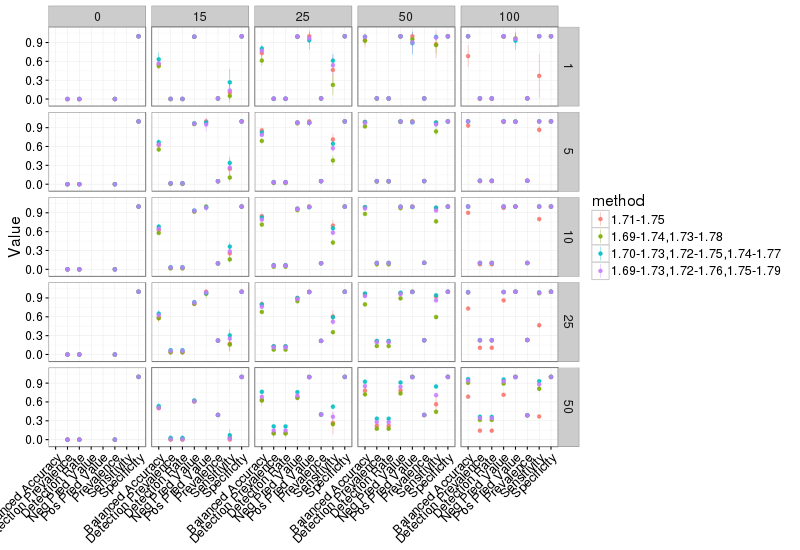

In [104]:
%%R -w 800 -h 550
# summarize by SIPSim rep & library rep
df_byClass.s = df_byClass %>%
    group_by(method, percIncorp, percTaxa, variables) %>%
    summarize(mean_value = mean(values),
              sd_value = sd(values))

# plotting
ggplot(df_byClass.s, aes(variables, mean_value, color=method,
                         ymin=mean_value-sd_value,
                         ymax=mean_value+sd_value)) +
    geom_pointrange(alpha=0.8, size=0.2) +
    labs(y='Value') +
    facet_grid(percTaxa ~ percIncorp) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=45, hjust=1)
    )

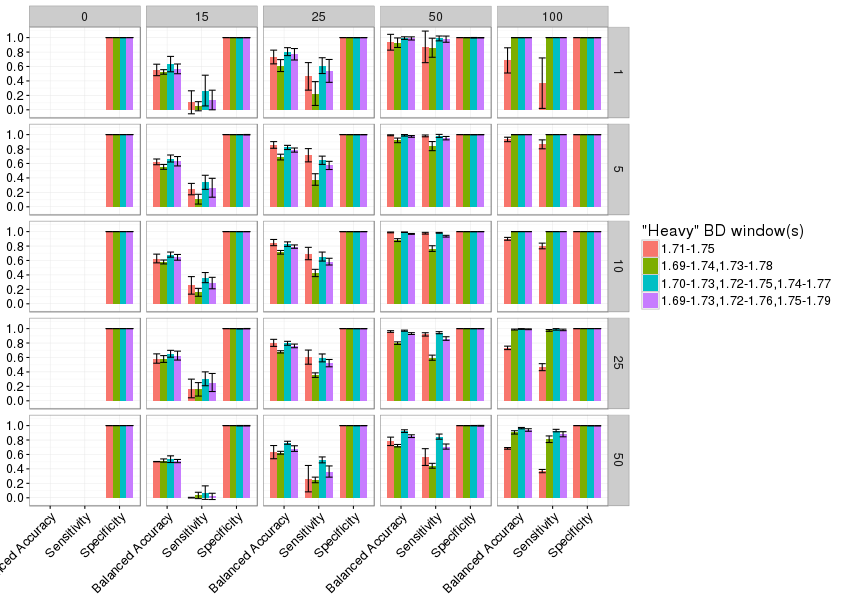

In [108]:
%%R -w 850 -h 600
# summarize by SIPSim rep & library rep
vars = c('Balanced Accuracy', 'Sensitivity', 'Specificity')
df_byClass.s.f = df_byClass.s %>%
    filter(variables %in% vars) 

# plotting
ggplot(df_byClass.s.f, aes(variables, mean_value, fill=method,
                         ymin=mean_value-sd_value,
                         ymax=mean_value+sd_value)) +
    #geom_pointrange(alpha=0.8, size=0.2) +
    geom_bar(stat='identity', position='dodge', width=0.8) +
    geom_errorbar(stat='identity', position='dodge', width=0.8) +
    scale_y_continuous(breaks=seq(0, 1, 0.2)) +
    scale_fill_discrete('"Heavy" BD window(s)') +
    facet_grid(percTaxa ~ percIncorp) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.y = element_blank()
    )